# This notebook compares ICESat-2 ATL11 to Alpine3D

In [40]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import glob
import geopandas as gpd
import pandas as pd
from datetime import datetime, timedelta

import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg
from osgeo import osr

# Open ATL11 file

In [41]:
# Open processed file
src_path = "../data/pt1_ATL11_042310_0309_003_01.nc"
ds_ATL11 = xr.open_dataset(src_path)
ds_ATL11

<xarray.Dataset>
Dimensions:                  (cycle: 7, x: 13177, y: 13177)
Coordinates:
  * y                        (y) float64 nan nan nan nan nan ... nan nan nan nan
  * cycle                    (cycle) int64 1 2 3 4 5 6 7
  * x                        (x) float64 nan nan nan nan nan ... nan nan nan nan
Data variables:
    Height                   (y, cycle) float32 ...
    Height_Sigma             (y, cycle) float32 ...
    Height_Sigma_Systematic  (y, cycle) float32 ...
    Time                     (y, cycle) float64 ...

# Open Alpine3D

In [42]:
ds_A3D = xr.open_dataset("../data/A3D-2015-2020-daily-snd.nc")
swe_A3D = xr.open_dataset("../data/A3D-2015-2020-daily-swe.nc")
xmin = ds_A3D['easting'].min().values
xmax = ds_A3D['easting'].max().values
ymin = ds_A3D['northing'].min().values
ymax = ds_A3D['northing'].max().values

In [43]:
ds_A3D

<xarray.Dataset>
Dimensions:   (easting: 168, northing: 107, time: 2192)
Coordinates:
  * time      (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2020-12-31
  * easting   (easting) float32 -1542500.0 -1541500.0 ... -1376500.0 -1375500.0
  * northing  (northing) float32 -108500.0 -107500.0 ... -3500.0 -2500.0
Data variables:
    snd       (time, northing, easting) float32 ...

# Make a map

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


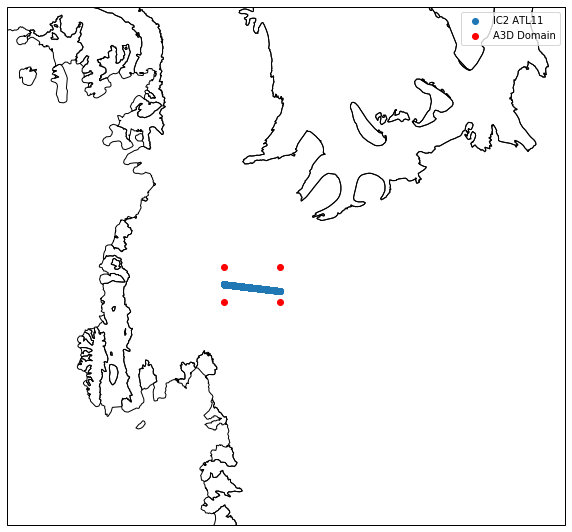

In [44]:
# Map
# Generate figure 
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(10, 10))

# Plot coastlines
axs.set_extent((-110, -70, -85, -70), ccrs.PlateCarree()) # Zoom in on Alpine-3D domain
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Plot ICESat-2
plt.scatter(ds_ATL11['x'], ds_ATL11['y'], transform=crs_epsg, label='IC2 ATL11')

# Plot model domain
plt.scatter(xmin, ymin, c='r', label="A3D Domain")
plt.scatter(xmin, ymax, c='r')
plt.scatter(xmax, ymin, c='r')
plt.scatter(xmax, ymax, c='r')
plt.legend()

# Plot observed change in height

In [45]:
def get_a3d_dh(ds_dh, ds_swe, t0, tf):
    '''
    Calculate the change in height from Alpine3D
    '''
    
    # Calculate delta height uncorrected
    dH = ds_dh['snd'].sel(time=tf) - ds_dh['snd'].sel(time=t0)
    
    # Calculate ice correction. Equal to average SMB in units ice equivalent over the period of interest
    smb = (ds_swe['swe'][-1, :, :] - ds_swe['swe'][0, :, :]) / 0.917 # Units: meters ice equivalent
    n_time = len(ds_swe['time'])
    smb = smb / n_time
    
    dt = tf - t0
    n_timesteps = dt.days
    dH_ice = smb * n_timesteps
    
    # Apply ice correction
    dH_corr = dH - dH_ice # Return Alpine3D delta height - ice correction
#     dH_corr = dH
#     dH_corr = - dH_ice
    
    return dH_corr

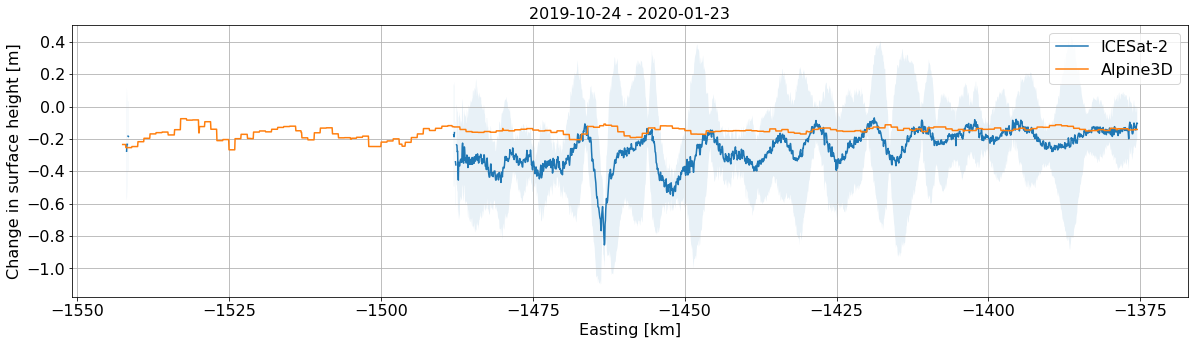

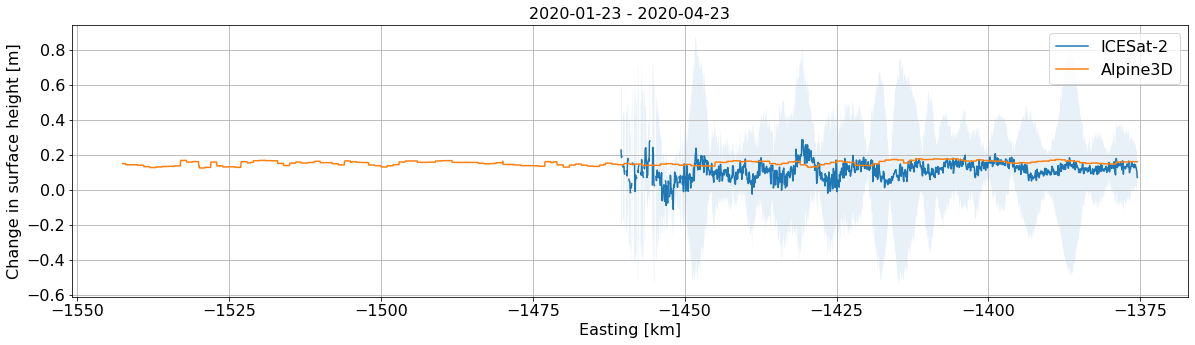

In [46]:
# Number of cylces
n_cycle = len(ds_ATL11['cycle'])

# Loop over each possible cycle difference
for j in range(0, n_cycle - 1):
    
    # Calculate observed delta height
    dh = ds_ATL11['Height'][:,j+1] - ds_ATL11['Height'][:,j]
    
    # Plot figure if we have data
    if np.count_nonzero(~np.isnan(dh)) != 0:
    
        # Calculate uncertainty 
        e0 = np.sqrt(ds_ATL11['Height_Sigma'][:,j]**2 + ds_ATL11['Height_Sigma_Systematic'][:,j]**2) # Total error of first height measurement 
        ef = np.sqrt(ds_ATL11['Height_Sigma'][:,j+1]**2 + ds_ATL11['Height_Sigma_Systematic'][:,j+1]**2) # Total error of second height measurement 
        e = np.sqrt(e0**2 + ef**2) # Total error of difference between second and third height measurement 

        # Easting (km)
        x = ds_ATL11['x'] / 1000

        # Retrieve time of measurement
        base_time = pd.Series(pd.date_range('2018-01-01', periods=1, freq='D'))
        t0 = pd.Timedelta(np.nanmean(ds_ATL11['Time'][:,j]), unit='s') + base_time
        t0 = datetime.strptime(np.datetime_as_string(t0, unit='D')[0], '%Y-%m-%d')
        tf = pd.Timedelta(np.nanmean(ds_ATL11['Time'][:,j+1]), unit='s') + base_time
        tf = datetime.strptime(np.datetime_as_string(tf, unit='D')[0], '%Y-%m-%d')
        
        # Calculate A3D dh
        dh_A3D = get_a3d_dh(ds_A3D, swe_A3D, t0, tf)
        tgt_x = xr.DataArray(ds_ATL11['x'].values, dims="points")
        tgt_y = xr.DataArray(ds_ATL11['y'].values, dims="points")
        dh_A3D = dh_A3D.sel(northing=tgt_y, easting=tgt_x, method='nearest')

        # Plot figure
        plt.figure(figsize=(20,5))
        plt.plot(x, dh, label='ICESat-2')
        plt.plot(x, dh_A3D, label='Alpine3D')
        plt.fill_between(x, dh - e, dh + e, alpha=0.1)
        plt.xlabel("Easting [km]", fontsize=16)
        plt.xticks(fontsize=16)
        plt.ylabel("Change in surface height [m]", fontsize=16)
        plt.yticks(fontsize=16)
        plt.grid()
        plt.legend(fontsize=16)
        plt.title(str(t0)[0:10] + " - " + str(tf)[0:10], fontsize=16)
